In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

2023-12-27 21:52:30:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /data/tmp. Using root: /data/tmp/tmpt5n30796


In [2]:
from rastervision.pipeline.file_system.utils import get_tmp_dir

get_tmp_dir()

<TemporaryDirectory '/data/tmp/tmpt5n30796/tmp_j9o7dxr'>

In [3]:
import os, torch
 #to prevent cuda out of memory error
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


#For reproducibility
torch.manual_seed(13)



### Configuration

In [4]:
from experiment_configs.configs import *
config = satmae_large_config_lora
# config.finetuning_strategy

### Create Rastervision datasets

In [5]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, scene_to_inference_ds
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

#find the highest cluster id
max_cluster_id = max([observation['cluster_id'] for observation in dataset_json])


# Randomly split the data into training and validation
val_split = random.randint(0, max_cluster_id+1)

training_scenes = []
validation_scenes = []

for observation in all_observations:
    if observation.cluster_id == val_split: 
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    # scene_to_validation_ds(config, scene) for scene in validation_scenes
    scene_to_inference_ds(config, scene, full_image=False, stride=int(config.tile_size/2)) for scene in validation_scenes # better performance with this
]

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)

print('Validation split cluster_id:', val_split)
print ('Training dataset size: {:4d} images | Number of observations: {:}'.format(len(train_dataset_merged), len(training_scenes)))
print ('Testing dataset size: {:4d}  images | Number of observations: {:}'.format(len(val_dataset_merged), len(validation_scenes)))

mine_percentage_aoi = characterize_dataset(training_scenes, validation_scenes)

2023-12-27 21:52:35:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif...
2023-12-27 21:52:36:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson...
2023-12-27 21:52:36:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack

 81%|########1 | 144M/177M [00:05<00:01, 30.0MB/s]

2023-12-27 21:52:52:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-02-01_annotations.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-02-01_annotations.geojson...
2023-12-27 21:52:52:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojson...
2023-12-27 21:52:52:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in

 77%|#######7  | 136M/176M [00:05<00:01, 28.5MB/s]

2023-12-27 21:52:59:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-05-01_annotations.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/annotations/Sone_Rohtas_84-21_24-91_2022-05-01_annotations.geojson...
2023-12-27 21:52:59:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojson.
2023-12-27 21:52:59:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_mining_median/labels/Sone_Rohtas_84-21_24-91_median/rivers/Sone_Rohtas_84-21_24-91_rivers_1000m.geojso

 90%|######### | 96.1M/106M [00:05<00:00, 19.2MB/s]

2023-12-27 21:53:50:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Betwa_Jalaun_79-79_25-89_median/annotations/Betwa_Jalaun_79-79_25-89_2022-10-01_annotations.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Betwa_Jalaun_79-79_25-89_median/annotations/Betwa_Jalaun_79-79_25-89_2022-10-01_annotations.geojson...
2023-12-27 21:53:50:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Betwa_Jalaun_79-79_25-89_median/rivers/Betwa_Jalaun_79-79_25-89_rivers_1000m.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Betwa_Jalaun_79-79_25-89_median/rivers/Betwa_Jalaun_79-79_25-89_rivers_1000m.geojson...
2023-12-27 21:53:50:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) spec

 84%|########3 | 110M/132M [00:05<00:00, 23.2MB/s]

2023-12-27 21:54:48:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Godavari_BhadradriKothagudem_80-79_18-04_median/annotations/Godavari_BhadradriKothagudem_80-79_18-04_2022-05-01_annotations.geojson to /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Godavari_BhadradriKothagudem_80-79_18-04_median/annotations/Godavari_BhadradriKothagudem_80-79_18-04_2022-05-01_annotations.geojson...
2023-12-27 21:54:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmpt5n30796/cache/http/storage.googleapis.com/sand_mining_median/labels/Godavari_BhadradriKothagudem_80-79_18-04_median/rivers/Godavari_BhadradriKothagudem_80-79_18-04_rivers_1000m.geojson.
2023-12-27 21:54:48:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_

Validation split cluster_id: 4
Training dataset size: 3088 images | Number of observations: 72
Testing dataset size: 1456  images | Number of observations: 8
Total dataset has 2.93%  mining area.
Training dataset has 3.05%  mining area.
Validation dataset has 2.15%  mining area.
Within AOIs, total dataset has 6.72%  mining area.
Outside AOIs, total dataset has 0.06%  mining area.

The median percentage of mine in an observation is 3.26%
The median number of mine pixels in an observation is 38059

The median number pixels in an observation is 1301008


## Update the loss weights to account for the imbalanced dataset

In [6]:
# config.mine_class_loss_weight = (100 - mine_percentage_aoi) / mine_percentage_aoi
# config.mine_class_loss_weight = 1
config.mine_class_loss_weight

6.0

## Visualize the datasets

In [7]:
from utils.visualizing import visualize_dataset

# print ('Training Dataset')
# for ds in training_datasets:
#     visualize_dataset(ds)

print("\n\n\n Val Dataset")

# for ds in validation_datasets:
#     visualize_dataset(ds)




 Val Dataset


# Train

In [8]:
from models.model_factory import model_factory, print_trainable_parameters
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner
from experiment_configs.configs import lora_config

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

print("Before LoRA: ")
print_trainable_parameters(model)


from peft import LoraConfig, get_peft_model


model = get_peft_model(model, lora_config)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)

print_trainable_parameters(learner.model)

SatMae: Loading encoder weights from /home/ando/sandmining-watch/out/weights/pretrain-vit-large-e199.pth
Position interpolate from 12x12 to 20x20
Warning! Missing keys:
['channel_cls_embed', 'head.weight', 'head.bias']
SatMaePretrained: Freezing encoder weights
Number of parameters loaded: 298
Before LoRA: 
trainable params: 0.991745M || all params: 304.273667M || trainable%: 0.33


2023-12-27 21:55:54:rastervision: INFO - train_ds: 3088 items
2023-12-27 21:55:54:rastervision: INFO - valid_ds: 1456 items


trainable params: 2.564609M || all params: 306.838276M || trainable%: 0.84


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [9]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
learner.initialize_wandb_run()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andoshah (sandmining-watch). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [11]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [15]:
learner.train(epochs=9) #9 is empirically the best for preventing overfitting on the training set
# Need to continue Fintetuning just the decosder for atleast 10 more epochs
#check -> https://wandb.ai/sandmining-watch/sandmine_detector/runs/mvuyz9n4

2023-12-28 07:52:34:rastervision: INFO - epoch: 0


Training:   0%|          | 0/386 [00:00<?, ?it/s]

Validating:   0%|          | 0/182 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Merge LoRA layers into the main model

In [13]:
# Save LoRA-only model locally
learner.model.save_pretrained(expanduser("~/sandmining-watch/out/OUTPUT_DIR/LoRA_only_model"))

In [14]:
print("Before merge: ")
print_trainable_parameters(learner.model)

learner.model = learner.model.merge_and_unload(safe_merge=True)
learner.save_model_weights(learner.last_model_weights_path)

print("After merge: ")
print_trainable_parameters(learner.model)


Before merge: 
trainable params: 2.564609M || all params: 306.838276M || trainable%: 0.84
Saving model weights to /home/ando/sandmining-watch/out/OUTPUT_DIR/last-model.pth
After merge: 
trainable params: 0.991745M || all params: 304.273667M || trainable%: 0.33


## Evaluate 

Initialize evaluation_datasets and predictor.
evaluation_datasets and validation_datasets are based on identical scenes, but have different sliding window configurations.

In [ ]:
config = satmae_large_inf_config

In [ ]:
from ml.learner import BinarySegmentationPredictor


predictor = BinarySegmentationPredictor(
    config,
    learner.model
    )



Temperature scaling set to None


  0%|          | 0/8 [00:00<?, ?it/s]

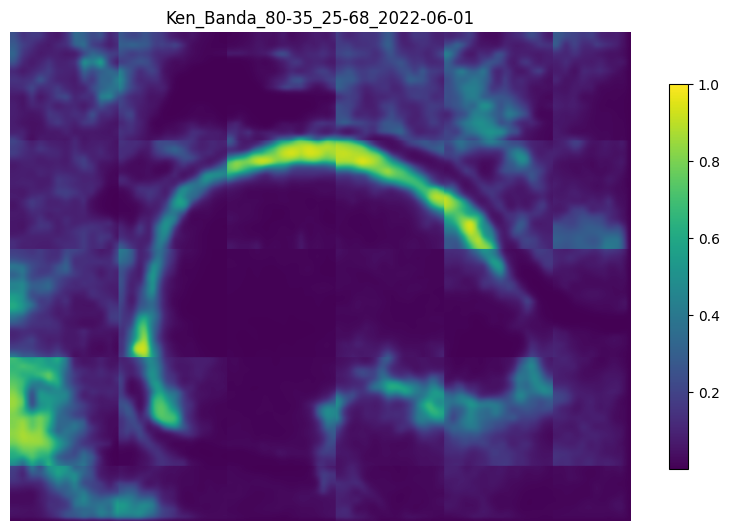

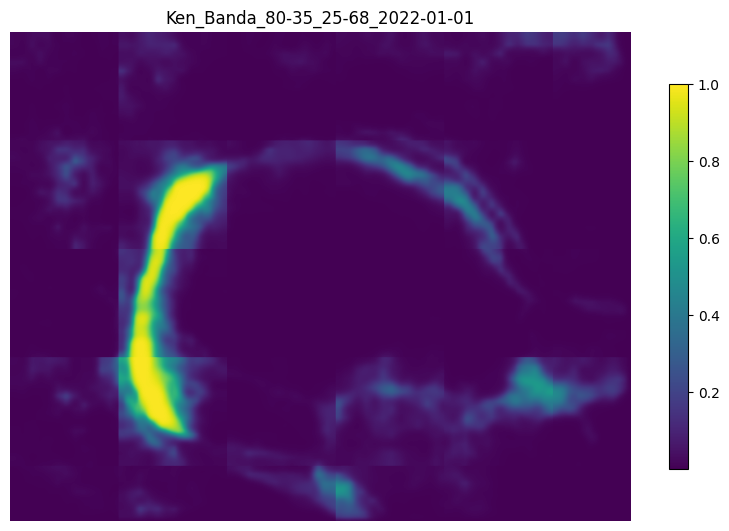

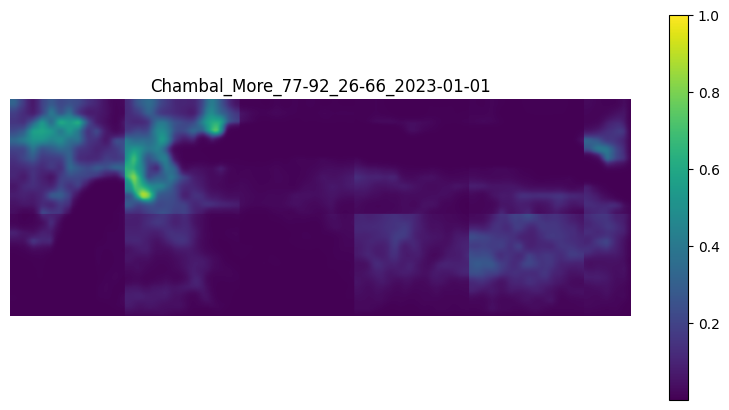

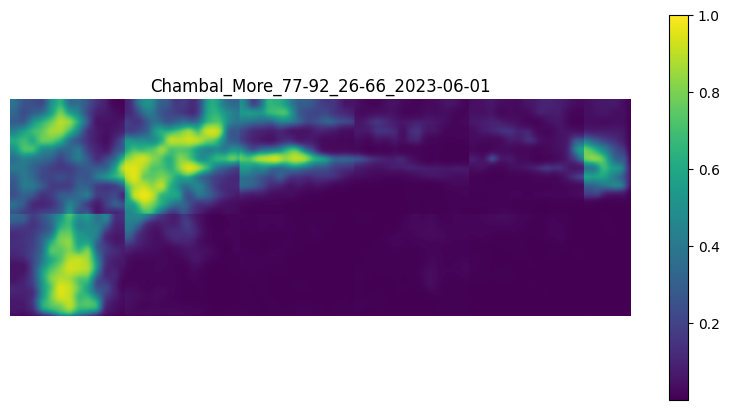

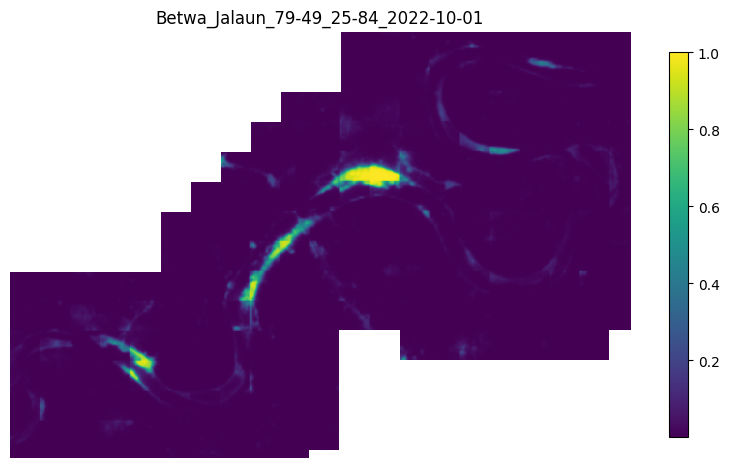

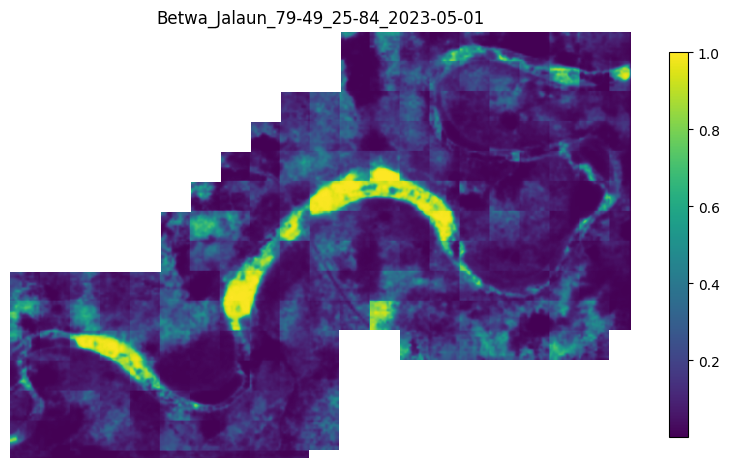

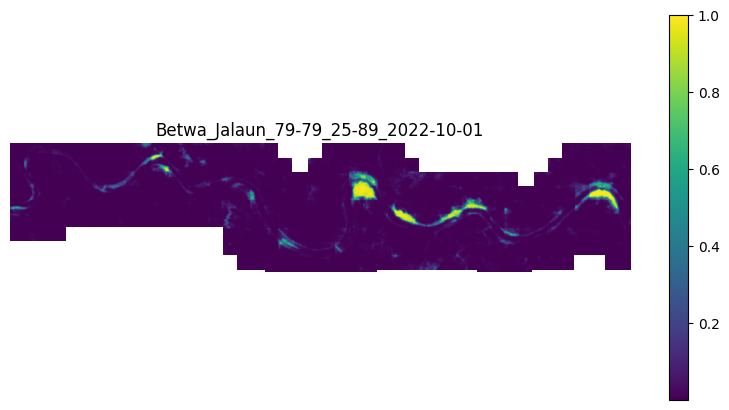

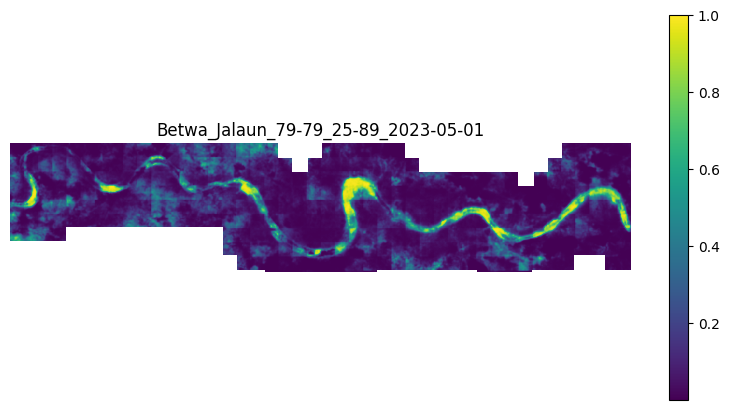

Best Threshold=0.555664, Best F1 Score=0.569
Best Threshold=0.743164, Best F1 Score=0.511
Best Threshold=0.743164, Best F1 Score=nan
Best Threshold=0.960938, Best F1 Score=nan
Best Threshold=0.367920, Best F1 Score=0.713
Best Threshold=0.724121, Best F1 Score=0.659
Best Threshold=0.524414, Best F1 Score=0.688
Best Threshold=0.627930, Best F1 Score=0.585
Best Threshold=0.631348, Best F1 Score=0.601


In [ ]:
from utils.visualizing import raster_source_to_rgb
from tqdm.notebook import tqdm
from ml.eval_utils import evaluate_predictions
import matplotlib.pyplot as plt

prediction_results_list = []
predictions = []

for ds in tqdm(validation_datasets):


    prediction = predictor.predict_site(ds, crop_sz=config.crop_sz) 
    #store predictions for later (to save as GeoTIFFs):
    predictions.append(prediction)

    # grab the prob arrays
    prediction_score = prediction.get_score_arr(prediction.extent)[0]

    rgb_img = raster_source_to_rgb(ds.scene.raster_source)
    prediction_results_list.append({
        "predictions": prediction_score,
        "ground_truth": ds.scene.label_source.get_label_arr(),
        "rgb_img": rgb_img,
        "name": ds.scene.id,
        "crop_sz": config.crop_sz,
    })

    #if prediction_score has any nan values, set them to -1
    # prediction_score = prediction_score.copy()
    # prediction_score[np.isnan(prediction_score)] = -1.

    
    #Now viz
    plt.figure(figsize=(10, 10))
    plt.imshow(prediction_score, vmax=1, cmap='viridis') 
    plt.axis('off')
    plt.title(ds.scene.id)
    #show colorbar at half scale
    plt.colorbar(shrink=0.5)
    plt.show()

evaluation_results_dict = evaluate_predictions(prediction_results_list)

## Pick the threshold that maximizes F1 score

In [ ]:
threshold = evaluation_results_dict['eval/total/best_threshold']
threshold

0.6313

In [ ]:
evaluation_results_dict


{'eval/Ken_Banda_80-35_25-68_2022-06-01/precision': 0.519100169779287,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/recall': 0.620560178607672,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/f1_score': 0.5653138578164001,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/average_precision': 0.6039037199941221,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_threshold': 0.5557,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_f1_score': 0.5689347149201164,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/precision': 0.5137637028014617,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/recall': 0.4078909196402669,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/f1_score': 0.4547463748584982,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/average_precision': 0.5514279299087087,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_threshold': 0.743,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_f1_score': 0.5109907613889774,
 'eval/Chambal_More_77-92_26-66_2023-01-01/precision': 0.019904458598726114,
 'eval/Chambal_More_77-92_26-66_2023-01-01/recall': 0.003392

Log results to Weights & Biases

In [ ]:
import wandb
from ml.eval_utils import make_wandb_segmentation_masks, make_wandb_predicted_probs_images

assert wandb.run is not None

# Add lists of W&B images to dict
evaluation_results_dict.update({
    'Segmentation masks': make_wandb_segmentation_masks(prediction_results_list, threshold),
    'Predicted probabilites': make_wandb_predicted_probs_images(prediction_results_list),
})

# Log to W&B
wandb.log(evaluation_results_dict)

In [17]:
import wandb
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


sandmine_average_precision,▁▁▅█▆▅▅▆▇
sandmine_best_f1_score,▁▁▄█▅▅▅▆▆
sandmine_best_threshold,█▆▁▇▃▅▆█▄
sandmine_f1,▁▄▆▆█▇▆▄█
sandmine_precision,▁▃█▃▆▅▄▂▆
sandmine_recall,▇▅▁█▅▅▅█▅
train_bce_loss,█▄▃▃▃▂▁▁▁
train_dice_loss,█▅▄▂▃▂▂▁▂
train_time_seconds,▁▅▅▅▆█▆▄▆
val_bce_loss,█▅▇▁▁▃▃▂▂
val_dice_loss,▇▅█▄▃▅▂▁▃
